In [2]:
import tensorflow as tf
from tensorflow import keras 

#Check tf.keras version
print(tf.keras.__version__)
import tensorflow as tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation,BatchNormalization
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

2.6.0


In [3]:
# Loading MNIST dataset
mnist = keras.datasets.mnist 
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
# Data Exploration
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


###Data Preprocessing

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32') 

In [6]:
# X_train is 60000 rows of 28x28 values; we reshape it to # 60000 x 784. 
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


## Designing the Model

### <b> Build the basic Generative Adversarial Model 

####Preparing the Model 0: Generative Adversarial network

#### <b>Part 1: Generator 

In [7]:
def build_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer= 'adam')
    return generator
g=build_generator()
g.summary()

2021-11-22 07:44:38.757228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 07:44:38.921131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 07:44:38.922198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

2021-11-22 07:44:38.924779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-22 07:44:38.926087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 07:44:38.927234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 07:44:38.928382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

#### <b>Part 2: Discriminator

In [8]:
def build_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy',optimizer= 'adam')
    return discriminator
d =build_discriminator()
d.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

#### <b>Part 3: Combined the Generator and Discriminator

- Create the GAN where Generator and Discriminator will be combined.
-  When we train the generator we will freeze the Discriminator.
- We will input the noised image of shape 100 units to the Generator.
- The output generated from the Generator will be fed to the Discriminator.

In [9]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


#### <b>Part 4: Visualize the images created by GAN

- Plot_generated_images to plot the generated images
- Can observe how the images are generated
- Save the generated images to file to view later

In [10]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

#### <b>Part 5: Train the model and print the output

Epoch 1


100%|██████████| 64/64 [00:04<00:00, 13.04it/s]


Epoch 2


  9%|▉         | 6/64 [00:00<00:02, 22.12it/s]2021-11-22 07:51:48.989387: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:51:49.001024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 14%|█▍        | 9/64 [00:00<00:03, 16.72it/s]2021-11-22 07:51:49.056675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:51:49.065834: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:51:49.116687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 17%|█▋        | 11/64 [00:00<00:03, 16.56it/s]2021-11-22 07:51:49.181907: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:51:49.241536: W tensorflow/core/data/root_dataset

Epoch 3


100%|██████████| 64/64 [00:02<00:00, 24.02it/s]


Epoch 4


100%|██████████| 64/64 [00:02<00:00, 21.65it/s]


Epoch 5


100%|██████████| 64/64 [00:02<00:00, 23.62it/s]


Epoch 6


  6%|▋         | 4/64 [00:00<00:04, 13.29it/s]2021-11-22 07:52:00.137050: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:00.187635: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 22.05it/s]


Epoch 7


100%|██████████| 64/64 [00:02<00:00, 23.11it/s]


Epoch 8


 33%|███▎      | 21/64 [00:00<00:01, 22.21it/s]2021-11-22 07:52:06.565233: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:06.580931: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 38%|███▊      | 24/64 [00:01<00:02, 18.88it/s]2021-11-22 07:52:06.631930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:06.641090: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 41%|████      | 26/64 [00:01<00:02, 18.00it/s]2021-11-22 07:52:06.763282: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:06.774693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:06.828784: W tensorflow/core/data/root_datas

Epoch 9


 75%|███████▌  | 48/64 [00:02<00:00, 23.58it/s]2021-11-22 07:52:10.833524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:10.843403: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 80%|███████▉  | 51/64 [00:02<00:00, 22.68it/s]2021-11-22 07:52:10.924060: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:10.933878: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:11.002739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:11.011269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 91%|█████████ | 58/64 [00:02<00:00, 17.28it/s]2021-11-22 07:52:11.380713: W tensorflow/core/data/root_datas

Epoch 10


100%|██████████| 64/64 [00:02<00:00, 22.78it/s]


Epoch 11


100%|██████████| 64/64 [00:02<00:00, 23.09it/s]


Epoch 12


100%|██████████| 64/64 [00:02<00:00, 23.67it/s]


Epoch 13


 70%|███████   | 45/64 [00:01<00:00, 20.39it/s]2021-11-22 07:52:22.061874: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:22.124685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:22.133668: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 78%|███████▊  | 50/64 [00:02<00:00, 17.70it/s]2021-11-22 07:52:22.312649: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:22.322669: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:22.401677: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:03<00:00, 21.14it/s]


Epoch 14


100%|██████████| 64/64 [00:02<00:00, 23.78it/s]


Epoch 15


100%|██████████| 64/64 [00:02<00:00, 23.49it/s]


Epoch 16


100%|██████████| 64/64 [00:02<00:00, 23.85it/s]


Epoch 17


 66%|██████▌   | 42/64 [00:01<00:00, 22.54it/s]2021-11-22 07:52:32.944746: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:32.957007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:33.024275: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 73%|███████▎  | 47/64 [00:02<00:00, 17.63it/s]2021-11-22 07:52:33.287684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:33.347682: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 21.85it/s]


Epoch 18


100%|██████████| 64/64 [00:02<00:00, 23.81it/s]


Epoch 19


100%|██████████| 64/64 [00:02<00:00, 23.75it/s]


Epoch 20


  3%|▎         | 2/64 [00:00<00:04, 13.82it/s]2021-11-22 07:52:39.614592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:39.623211: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
  6%|▋         | 4/64 [00:00<00:04, 13.39it/s]2021-11-22 07:52:39.750847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:39.759553: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:39.808162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 16%|█▌        | 10/64 [00:00<00:04, 13.08it/s]2021-11-22 07:52:40.214496: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:40.225538: W tensorflow/core/data/root_dataset

Epoch 21


100%|██████████| 64/64 [00:02<00:00, 23.69it/s]


Epoch 22


100%|██████████| 64/64 [00:02<00:00, 23.46it/s]


Epoch 23


100%|██████████| 64/64 [00:02<00:00, 24.10it/s]


Epoch 24


 45%|████▌     | 29/64 [00:01<00:02, 16.78it/s]2021-11-22 07:52:55.259679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:52:55.275673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:03<00:00, 20.30it/s]


Epoch 25


100%|██████████| 64/64 [00:02<00:00, 23.51it/s]


Epoch 26


100%|██████████| 64/64 [00:02<00:00, 23.92it/s]


Epoch 27


100%|██████████| 64/64 [00:02<00:00, 23.62it/s]


Epoch 28


 28%|██▊       | 18/64 [00:00<00:01, 24.11it/s]2021-11-22 07:53:06.011340: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:06.023247: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 33%|███▎      | 21/64 [00:00<00:02, 18.63it/s]2021-11-22 07:53:06.082194: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:06.090724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:06.152075: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:06.163683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:06.225684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled:

Epoch 29


100%|██████████| 64/64 [00:02<00:00, 23.81it/s]


Epoch 30


 70%|███████   | 45/64 [00:01<00:00, 21.82it/s]2021-11-22 07:53:12.667768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:12.791377: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:12.800170: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 75%|███████▌  | 48/64 [00:02<00:00, 18.95it/s]2021-11-22 07:53:12.852095: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:12.914010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:12.922417: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 78%|███████▊  | 50/64 [00:02<00:00, 18.29it/s]2021-11-22 07:53:12.974849: W tensorflow/core/data/root_datas

Epoch 31


100%|██████████| 64/64 [00:02<00:00, 23.48it/s]


Epoch 32


  9%|▉         | 6/64 [00:00<00:02, 23.56it/s]2021-11-22 07:53:16.840040: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:16.903324: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:16.912520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 14%|█▍        | 9/64 [00:00<00:03, 17.37it/s]2021-11-22 07:53:17.058977: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:17.068744: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:17.124606: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:17.135675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: O

Epoch 33


100%|██████████| 64/64 [00:02<00:00, 23.47it/s]


Epoch 34


100%|██████████| 64/64 [00:02<00:00, 23.29it/s]


Epoch 35


100%|██████████| 64/64 [00:02<00:00, 24.00it/s]


Epoch 36


  5%|▍         | 3/64 [00:00<00:02, 24.54it/s]2021-11-22 07:53:27.838378: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:27.924232: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:28.006752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
  9%|▉         | 6/64 [00:00<00:03, 15.33it/s]2021-11-22 07:53:28.070031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:28.078719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:28.135454: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:28.147671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: O

Epoch 37


100%|██████████| 64/64 [00:02<00:00, 23.62it/s]


Epoch 38


100%|██████████| 64/64 [00:02<00:00, 23.34it/s]


Epoch 39


100%|██████████| 64/64 [00:02<00:00, 23.73it/s]


Epoch 40


  0%|          | 0/64 [00:00<?, ?it/s]2021-11-22 07:53:38.868706: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:38.963372: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
  3%|▎         | 2/64 [00:00<00:05, 11.68it/s]2021-11-22 07:53:39.026385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:39.035281: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:39.089249: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 21.78it/s]


Epoch 41


 19%|█▉        | 12/64 [00:00<00:02, 23.82it/s]2021-11-22 07:53:45.489795: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:45.562346: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 23%|██▎       | 15/64 [00:00<00:02, 18.82it/s]2021-11-22 07:53:45.716780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:45.790691: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:45.843440: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 31%|███▏      | 20/64 [00:01<00:02, 16.14it/s]2021-11-22 07:53:46.042281: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:46.051368: W tensorflow/core/data/root_datas

Epoch 42


 75%|███████▌  | 48/64 [00:02<00:00, 19.53it/s]2021-11-22 07:53:50.160499: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:50.169746: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:50.221684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:50.230672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:50.288665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 80%|███████▉  | 51/64 [00:02<00:00, 18.23it/s]2021-11-22 07:53:50.346675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:53:50.355844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled:

Epoch 43


100%|██████████| 64/64 [00:03<00:00, 20.66it/s]


Epoch 44


100%|██████████| 64/64 [00:02<00:00, 23.73it/s]


Epoch 45


100%|██████████| 64/64 [00:02<00:00, 23.82it/s]


Epoch 46


 56%|█████▋    | 36/64 [00:01<00:01, 20.58it/s]2021-11-22 07:54:00.984886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:00.997277: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 64%|██████▍   | 41/64 [00:01<00:01, 18.32it/s]2021-11-22 07:54:01.304237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:01.312841: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:01.376239: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 22.12it/s]


Epoch 47


100%|██████████| 64/64 [00:02<00:00, 23.72it/s]


Epoch 48


100%|██████████| 64/64 [00:02<00:00, 24.25it/s]


Epoch 49


100%|██████████| 64/64 [00:02<00:00, 23.47it/s]


Epoch 50


 56%|█████▋    | 36/64 [00:01<00:01, 22.33it/s]2021-11-22 07:54:11.948434: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:11.962079: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:12.033253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:12.043193: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:12.112679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 61%|██████    | 39/64 [00:01<00:01, 17.86it/s]2021-11-22 07:54:12.178670: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:12.190689: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled:

Epoch 51


100%|██████████| 64/64 [00:02<00:00, 23.78it/s]


Epoch 52


100%|██████████| 64/64 [00:02<00:00, 22.63it/s]


Epoch 53


  0%|          | 0/64 [00:00<?, ?it/s]2021-11-22 07:54:18.860030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:18.869408: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:18.946763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
  3%|▎         | 2/64 [00:00<00:04, 14.10it/s]2021-11-22 07:54:19.015724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:19.024111: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
  6%|▋         | 4/64 [00:00<00:04, 13.09it/s]2021-11-22 07:54:19.157518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:19.167483: W tensorflow/core/data/root_dataset.cc:167] 

Epoch 54


 38%|███▊      | 24/64 [00:01<00:01, 21.85it/s]2021-11-22 07:54:22.982687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:23.039288: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:23.050107: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:23.107694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:23.118675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 42%|████▏     | 27/64 [00:01<00:02, 18.05it/s]2021-11-22 07:54:23.183677: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:23.193834: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled:

Epoch 55


100%|██████████| 64/64 [00:02<00:00, 23.42it/s]


Epoch 56


100%|██████████| 64/64 [00:02<00:00, 23.32it/s]


Epoch 57


100%|██████████| 64/64 [00:02<00:00, 23.20it/s]


Epoch 58


 27%|██▋       | 17/64 [00:00<00:02, 23.09it/s]2021-11-22 07:54:33.877355: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:33.886721: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:33.960709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:33.969893: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:34.022859: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:34.035675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 31%|███▏      | 20/64 [00:00<00:02, 18.26it/s]2021-11-22 07:54:34.092991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled:

Epoch 59


100%|██████████| 64/64 [00:02<00:00, 23.19it/s]


Epoch 60


100%|██████████| 64/64 [00:02<00:00, 24.00it/s]


Epoch 61


 27%|██▋       | 17/64 [00:00<00:02, 20.92it/s]2021-11-22 07:54:45.036473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:45.048690: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:45.114670: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:03<00:00, 20.18it/s]


Epoch 62


100%|██████████| 64/64 [00:03<00:00, 19.75it/s]


Epoch 63


 38%|███▊      | 24/64 [00:01<00:01, 24.08it/s]2021-11-22 07:54:51.738199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:51.748381: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 42%|████▏     | 27/64 [00:01<00:01, 20.60it/s]2021-11-22 07:54:51.876331: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:51.949935: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:51.958881: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 47%|████▋     | 30/64 [00:01<00:01, 18.17it/s]2021-11-22 07:54:52.027363: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:52.114928: W tensorflow/core/data/root_datas

Epoch 64


 80%|███████▉  | 51/64 [00:02<00:00, 23.72it/s]2021-11-22 07:54:55.891980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:55.993673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 84%|████████▍ | 54/64 [00:02<00:00, 19.68it/s]2021-11-22 07:54:56.055565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:56.117049: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 89%|████████▉ | 57/64 [00:02<00:00, 18.54it/s]2021-11-22 07:54:56.234675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:56.247678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:54:56.316680: W tensorflow/core/data/root_datas

Epoch 65


100%|██████████| 64/64 [00:02<00:00, 23.79it/s]


Epoch 66


100%|██████████| 64/64 [00:02<00:00, 23.19it/s]


Epoch 67


100%|██████████| 64/64 [00:02<00:00, 23.71it/s]


Epoch 68


 73%|███████▎  | 47/64 [00:02<00:00, 23.29it/s]2021-11-22 07:55:06.865648: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:06.942184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:06.952952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:07.023677: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 78%|███████▊  | 50/64 [00:02<00:00, 18.54it/s]2021-11-22 07:55:07.164705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:07.237089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:03<00:00, 21.10it/s]


Epoch 69


100%|██████████| 64/64 [00:02<00:00, 23.95it/s]


Epoch 70


100%|██████████| 64/64 [00:02<00:00, 23.96it/s]


Epoch 71


100%|██████████| 64/64 [00:02<00:00, 22.93it/s]


Epoch 72


 75%|███████▌  | 48/64 [00:02<00:00, 19.06it/s]2021-11-22 07:55:18.174683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:18.182684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:18.243670: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:18.253595: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 21.84it/s]


Epoch 73


100%|██████████| 64/64 [00:02<00:00, 23.73it/s]


Epoch 74


100%|██████████| 64/64 [00:02<00:00, 24.00it/s]


Epoch 75


 19%|█▉        | 12/64 [00:00<00:02, 23.39it/s]2021-11-22 07:55:24.906435: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:24.915693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:24.970912: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:24.979663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 23%|██▎       | 15/64 [00:00<00:02, 17.56it/s]2021-11-22 07:55:25.032578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:25.041142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:25.093689: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled:

Epoch 76


 56%|█████▋    | 36/64 [00:01<00:01, 23.01it/s]2021-11-22 07:55:29.013683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:29.022494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:29.076860: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:29.085994: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 61%|██████    | 39/64 [00:01<00:01, 18.05it/s]2021-11-22 07:55:29.140868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:29.154680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:29.205847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled:

Epoch 77


100%|██████████| 64/64 [00:02<00:00, 22.94it/s]


Epoch 78


100%|██████████| 64/64 [00:02<00:00, 23.01it/s]


Epoch 79


100%|██████████| 64/64 [00:02<00:00, 23.93it/s]


Epoch 80


 47%|████▋     | 30/64 [00:01<00:01, 24.14it/s]2021-11-22 07:55:39.890022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:40.040677: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 52%|█████▏    | 33/64 [00:01<00:01, 18.86it/s]2021-11-22 07:55:40.181682: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:40.246684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 21.82it/s]


Epoch 81


100%|██████████| 64/64 [00:03<00:00, 18.86it/s]


Epoch 82


100%|██████████| 64/64 [00:02<00:00, 23.34it/s]


Epoch 83


 23%|██▎       | 15/64 [00:00<00:02, 18.80it/s]2021-11-22 07:55:51.157688: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:51.167684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 21.63it/s]


Epoch 84


100%|██████████| 64/64 [00:02<00:00, 23.23it/s]


Epoch 85


 66%|██████▌   | 42/64 [00:01<00:00, 23.08it/s]2021-11-22 07:55:57.956156: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:57.965960: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 70%|███████   | 45/64 [00:02<00:00, 19.23it/s]2021-11-22 07:55:58.019120: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:58.097789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:58.108661: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:58.166688: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:55:58.175612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled:

Epoch 86


 89%|████████▉ | 57/64 [00:02<00:00, 22.73it/s]2021-11-22 07:56:01.829370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:01.839215: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 94%|█████████▍| 60/64 [00:02<00:00, 22.14it/s]2021-11-22 07:56:01.932441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:02.070219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 98%|█████████▊| 63/64 [00:02<00:00, 18.23it/s]2021-11-22 07:56:02.128681: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:02.142687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 21.79it/s]


Epoch 87


100%|██████████| 64/64 [00:02<00:00, 22.16it/s]


Epoch 88


100%|██████████| 64/64 [00:02<00:00, 22.83it/s]


Epoch 89


100%|██████████| 64/64 [00:02<00:00, 23.41it/s]


Epoch 90


 84%|████████▍ | 54/64 [00:02<00:00, 19.56it/s]2021-11-22 07:56:13.047753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:13.056761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:13.181683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 89%|████████▉ | 57/64 [00:02<00:00, 17.76it/s]2021-11-22 07:56:13.317683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:13.326707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:02<00:00, 21.59it/s]


Epoch 91


100%|██████████| 64/64 [00:02<00:00, 23.11it/s]


Epoch 92


100%|██████████| 64/64 [00:02<00:00, 23.83it/s]


Epoch 93


100%|██████████| 64/64 [00:02<00:00, 23.40it/s]


Epoch 94


100%|██████████| 64/64 [00:03<00:00, 21.21it/s]


Epoch 95


100%|██████████| 64/64 [00:02<00:00, 21.53it/s]


Epoch 96


100%|██████████| 64/64 [00:02<00:00, 23.07it/s]


Epoch 97


  9%|▉         | 6/64 [00:00<00:02, 23.62it/s]2021-11-22 07:56:30.842133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:31.000901: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 14%|█▍        | 9/64 [00:00<00:03, 17.83it/s]2021-11-22 07:56:31.077807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:31.150420: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 20%|██        | 13/64 [00:00<00:03, 14.41it/s]2021-11-22 07:56:31.395400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:31.404806: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:31.472877: W tensorflow/core/data/root_dataset

Epoch 98


 42%|████▏     | 27/64 [00:01<00:01, 18.63it/s]2021-11-22 07:56:35.045308: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:35.169173: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
 50%|█████     | 32/64 [00:01<00:01, 17.20it/s]2021-11-22 07:56:35.367091: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-11-22 07:56:35.377231: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|██████████| 64/64 [00:03<00:00, 21.26it/s]


Epoch 99


100%|██████████| 64/64 [00:02<00:00, 23.28it/s]


Epoch 100


100%|██████████| 64/64 [00:02<00:00, 23.54it/s]


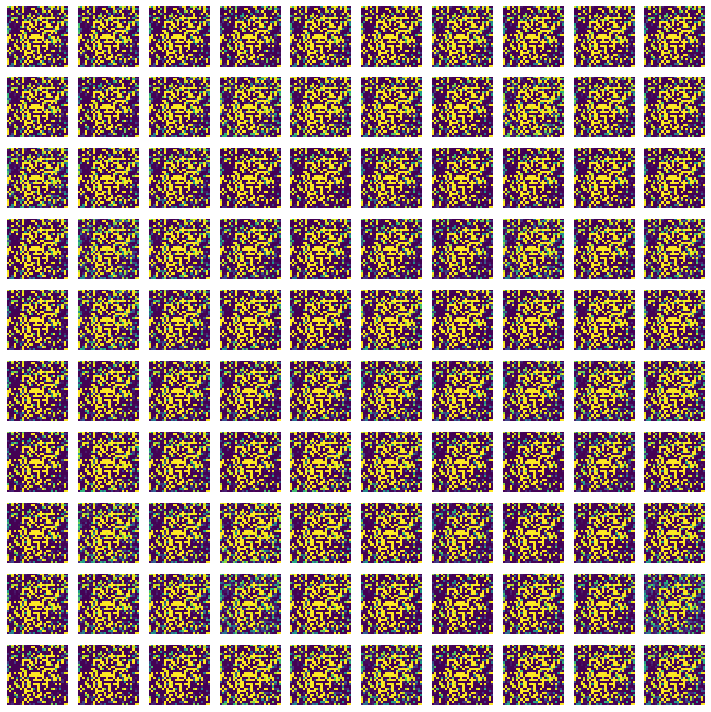

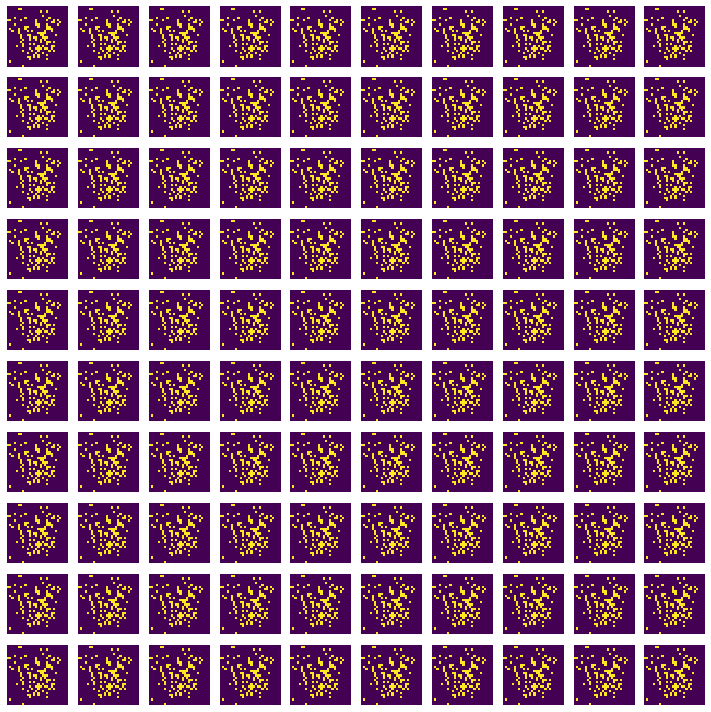

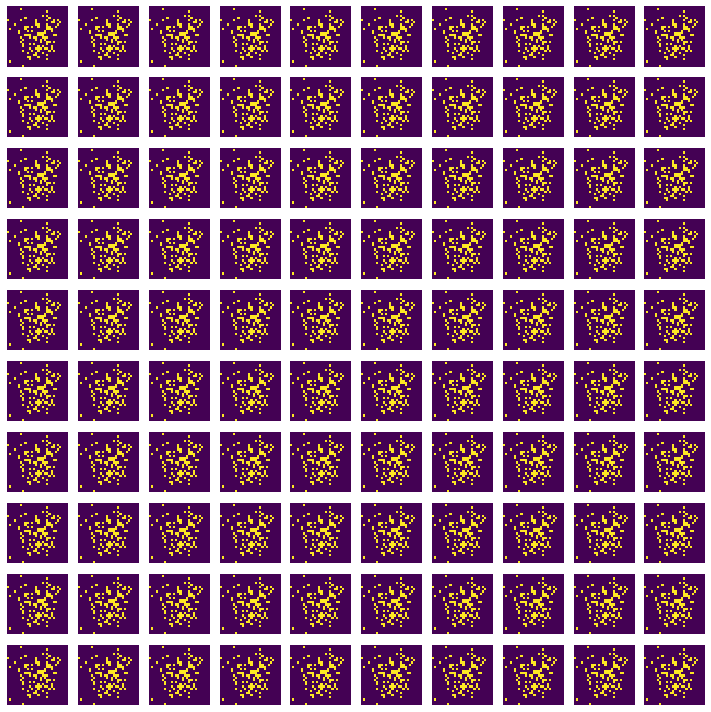

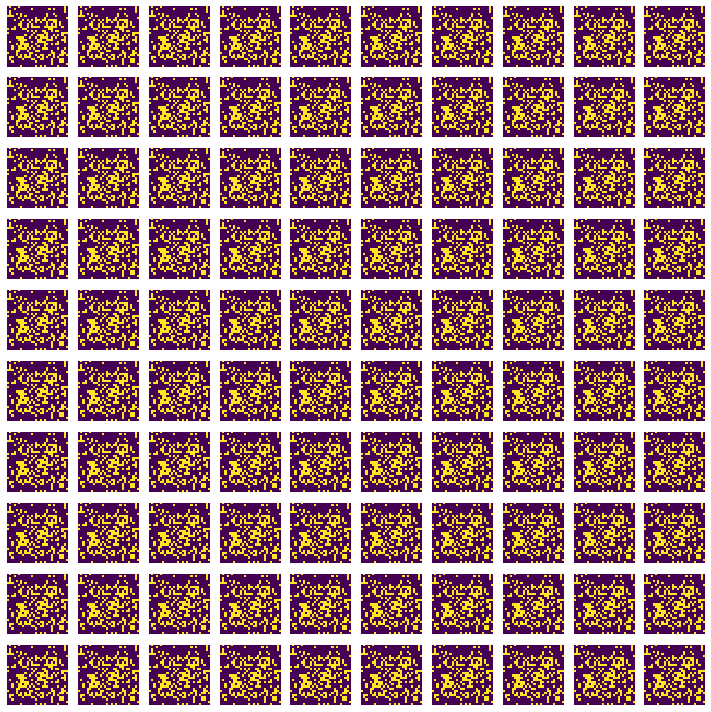

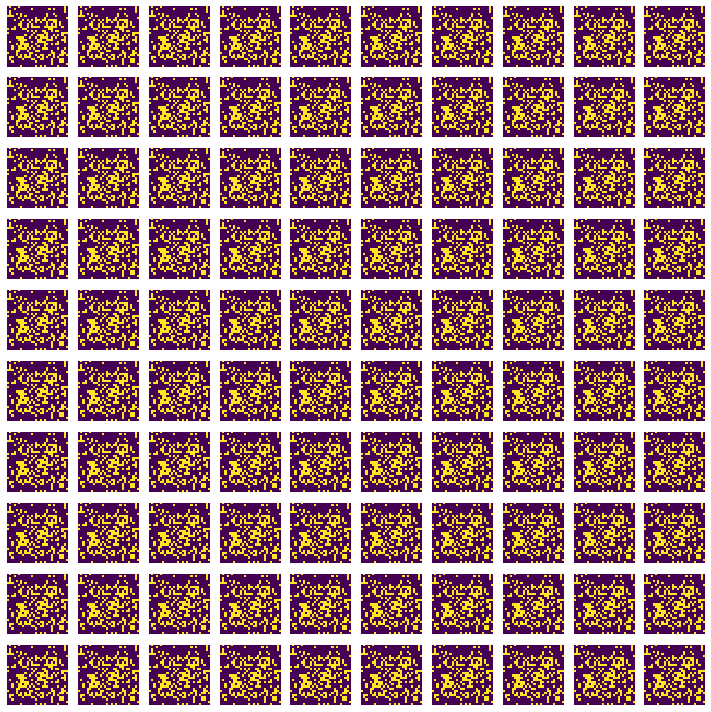

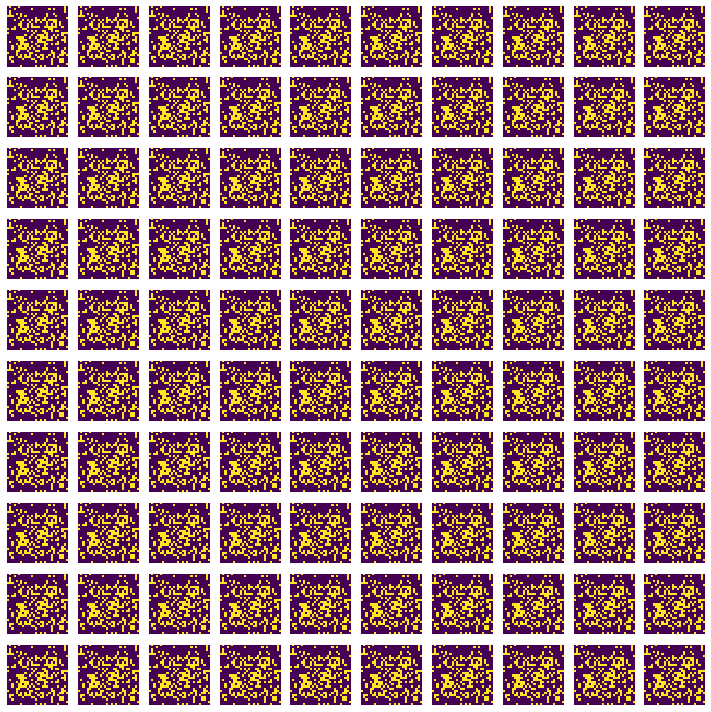

In [11]:
def training(epochs=100, batch_size=64):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= build_generator()
    discriminator= build_discriminator()
    gan = create_gan(discriminator, generator)
     
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(100,64)

##### <b>As the output of vanilla GAN is not satisfactory we can try some other techniques. 
Number of epochs can be increased to improve the accuracy

### <b> Build the Deep convolutional Generative Adversarial Model 

In [87]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display

In [88]:
tf.random.set_seed(42)

In [89]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [90]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [91]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [92]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [93]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation,BatchNormalization,LeakyReLU,Conv2DTranspose,Reshape
def generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

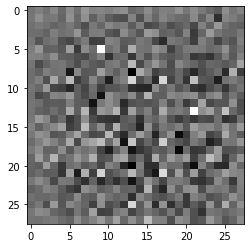

In [95]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [96]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [97]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5003025]], shape=(1, 1), dtype=float32)


In [98]:
from tensorflow.keras.losses import BinaryCrossentropy
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy(from_logits=True)

In [99]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [100]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [101]:
from tensorflow.keras.optimizers import Adam
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [102]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

##### <b>As the output of vanilla GAN is not satisfactory we can try some other techniques. 
Number of epochs can be increased to improve the accuracy

#### <b>Part 7: Train the model

In [103]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [104]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

#### <b>Part 8: Generate and save the model

In [105]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

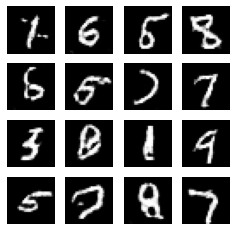

In [106]:
train(train_dataset,epochs=100)

#### <b>Part 9: Visualize the Final output

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/image_at_epoch_0050.png')
imgplot = plt.imshow(img)
plt.show()